# Предобработка датасета

Подключение библиотек

In [1]:
import pandas as pd
import spacy
from nltk.corpus import stopwords
from tqdm.auto import tqdm, trange

Чтение датасета

In [2]:
dataset = pd.read_excel('М.Тех_ТЗ_Датасет_DS_NLP.xlsx', index_col=0)

### Предобработка текста отзывов

Удаление знаков препинания

In [3]:
dataset['text_clean'] = dataset['text'].replace(r'[^\w\s]', ' ', regex=True).replace(r'\s+', ' ', regex=True).str.lower()

Лемматизация

In [4]:
nlp = spacy.load("ru_core_news_lg")
lemma = []
for doc in nlp.pipe(dataset["text_clean"].values):
    lemma.append([n.lemma_ for n in doc])
dataset['text_clean_lemma'] = lemma

Удаление стоп-слов

In [5]:
stopwords_ru = stopwords.words("russian")
dataset['text_clean_lemma'] = dataset['text_clean_lemma'].apply(lambda x: [item for item in x if item not in stopwords_ru])
dataset['text_clean_lemma_as_str'] = [' '.join(map(str, l)) for l in dataset['text_clean_lemma']]

In [6]:
dataset.drop(["id", "text", 'text_clean', 'text_clean_lemma'], axis=1, inplace=True) # удаляю лишние колонки
dataset["class id"] = dataset['class'].replace(dataset['class'].unique(), range(8)) # добавляю id меток классов


In [7]:
dataset.to_csv('CleanedData.csv', sep='\t', encoding='utf-8') # сохраняю новый файл с подготовленной датой

# Реализация модели классификации негативных отзывов

Подключение библиотек

In [8]:
import matplotlib.pyplot as plt

Подключение подготовленного датасета

In [9]:
dataset = pd.read_csv('CleanedData.csv', sep='\t', encoding='utf-8')

Pаспределение отзывов по меткам

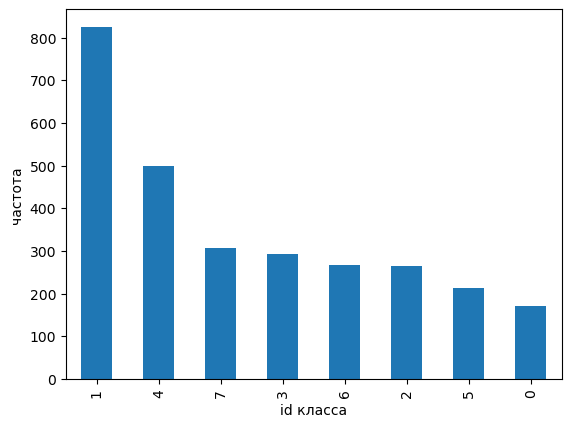

In [10]:
am = dataset['class id'].value_counts()
dataset['class id'].value_counts().plot(kind='bar', xlabel='id класса', ylabel='частота')
plt.show()

### Разделение датасета на тренировочную и тестовую выборки

Подключение библиотек

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [12]:
def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=40, stratify=dataset['class'])

y_train = X_train["class id"].tolist()
X_train = X_train["text_clean_lemma_as_str"].tolist()
y_test = X_test["class id"].tolist()
X_test = X_test["text_clean_lemma_as_str"].tolist()

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

Реализация метрики f1 для оценки точности работы модели

In [13]:
%%time
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
def get_metrics(y_test, y_predicted):
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None, average='weighted')
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None, average='weighted')

    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')

    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    
    return accuracy, precision, recall, f1

CPU times: total: 0 ns
Wall time: 0 ns


In [14]:
%%time
# логистическия регрессия
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)
y_predicted_counts = clf.predict(X_test_counts)

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.803, precision = 0.804, recall = 0.803, f1 = 0.803
CPU times: total: 62.5 ms
Wall time: 3.09 s


In [15]:
%%time
# наивный байес
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train_counts, y_train)
y_predicted_counts = clf.predict(X_test_counts)

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))




accuracy = 0.680, precision = 0.738, recall = 0.680, f1 = 0.664
CPU times: total: 31.2 ms
Wall time: 24 ms


In [16]:
%%time
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train_counts, y_train)
y_predicted_counts = clf.predict(X_test_counts)

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))


accuracy = 0.732, precision = 0.750, recall = 0.732, f1 = 0.715
CPU times: total: 2.44 s
Wall time: 2.82 s


In [17]:
%%time
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier()
clf.fit(X_train_counts, y_train)
y_predicted_counts = clf.predict(X_test_counts)

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.775, precision = 0.776, recall = 0.775, f1 = 0.774
CPU times: total: 234 ms
Wall time: 153 ms


Из протестированных алгоритмов (LogisticRegression, MultinomialNB, RandomForestClassifier, SGDClassifier) по метрике f1 лучший результат показала логистическая регрессия (LogisticRegression), вследствие чего и была выбрана как модель.

Обучение модели на всем подготовленной датасете

In [18]:
from joblib import dump, load

In [19]:
X_train = dataset["text_clean_lemma_as_str"].tolist()
y_train = dataset["class id"].tolist()

X_train_counts, count_vectorizer = cv(X_train)
dump(count_vectorizer, "vectorizer.pkl") # сохранение класса со словарем
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)
dump(clf, 'model.joblib') # сохранение модели

['model.joblib']

Реализация функции get_result

In [20]:
def get_result(text):
    text = text.replace(r'[^\w\s]', ' ', regex=True).replace(r'\s+', ' ', regex=True).str.lower()
    # лемматизация
    nlp = spacy.load("ru_core_news_lg")
    lemma = []
    for doc in nlp.pipe(text.values):
        lemma.append([n.lemma_ for n in doc])
    text = pd.Series(lemma)
    # убираем стоп-слова
    stopwords_ru = stopwords.words("russian")
    text = text.apply(lambda x: [item for item in x if item not in stopwords_ru])
    text = [' '.join(map(str, l)) for l in text]
    # разделение данных
    count_vectorizer = load('vectorizer.pkl')
    X_test_counts = count_vectorizer.transform(text)
    clf = load('model.joblib')
    list = ['Консультация КЦ', 'Компетентность продавцов/ консультантов',
            'Электронная очередь', 'Доступность персонала в магазине',
            'Вежливость сотрудников магазина', 'Обслуживание на кассе',
            'Обслуживание продавцами/ консультантами',
            'Время ожидания у кассы']
    y_predicted_counts = pd.Series(clf.predict(X_test_counts))
    y_predicted_counts = y_predicted_counts.replace(range(8), list)
    return y_predicted_counts

In [24]:
test = pd.Series(['Мальчики грубые ругают кричат',
                   'Ждала 10 часов у кассы, а кассир-то и не пришел!',
                   'Сдачу не дали, сказали размена не, мдаа ну и кассиры !!!',
                   'Консультанты сами не знают что продают'])
print(test)
print(get_result(test))

0                        Мальчики грубые ругают кричат
1     Ждала 10 часов у кассы, а кассир-то и не пришел!
2    Сдачу не дали, сказали размена не, мдаа ну и к...
3               Консультанты сами не знают что продают
dtype: object
0            Вежливость сотрудников магазина
1                      Обслуживание на кассе
2                      Обслуживание на кассе
3    Компетентность продавцов/ консультантов
dtype: object
